In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

sns.set(style='whitegrid')
plt.rcParams["figure.figsize"]=(20, 10)
pd.set_option('display.float_format', lambda x: '%f' % x)

dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/

In [2]:
iris = pd.read_csv('iris.csv')

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


In [4]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Hold-out

In [6]:
def hold_out(*, data: pd.core.frame.DataFrame, test_size: float, shuffle: bool, columns: list = []):

    if len(list(columns)) > 0: 
        new = data.filter(list(columns), axis=1)
    else:
        new = data.copy()

    if shuffle:
        mask = np.random.rand(len(data)) < test_size
    else:
        a = np.linspace(0, 1.0, len(data))
        mask = a < test_size

    return new[~mask], new[mask]

#### Natural order

In [7]:
train, test = hold_out(data=iris, test_size=0.3, shuffle=False)

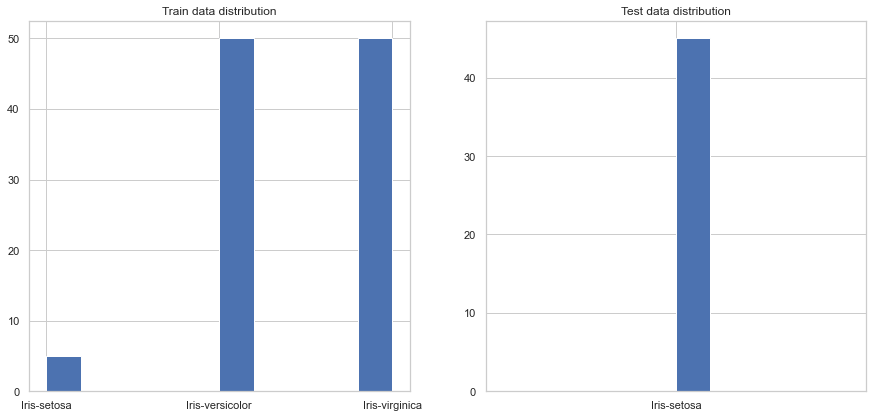

In [8]:
plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
train['class'].hist()
plt.title('Train data distribution')

plt.subplot(2, 2, 2)
test['class'].hist()
plt.title('Test data distribution')

plt.show()

In [9]:
train.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,105.000000,105.000000,105.000000,105.000000
mean,6.200000,2.897143,4.741905,1.606667
std,0.706154,0.350126,1.092173,0.518553
min,4.600000,2.000000,1.400000,0.200000
25%,5.700000,2.700000,4.200000,1.300000
50%,6.200000,2.900000,4.800000,1.500000
75%,6.700000,3.100000,5.500000,2.000000
max,7.900000,3.800000,6.900000,2.500000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 45 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  105 non-null    float64
 1   sepal_width   105 non-null    float64
 2   petal_length  105 non-null    float64
 3   petal_width   105 non-null    float64
 4   class         105 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.9+ KB


#### Randomized

In [11]:
train, test = hold_out(data=iris, test_size=0.3, shuffle=True, columns=iris.columns.values)

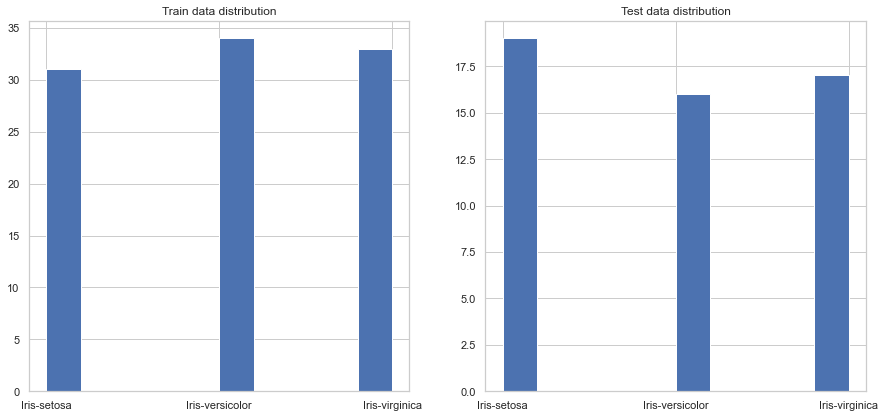

In [12]:
plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
train['class'].hist()
plt.title('Train data distribution')

plt.subplot(2, 2, 2)
test['class'].hist()
plt.title('Test data distribution')

plt.show()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  98 non-null     float64
 1   sepal_width   98 non-null     float64
 2   petal_length  98 non-null     float64
 3   petal_width   98 non-null     float64
 4   class         98 non-null     object 
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [14]:
train.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,98.000000,98.000000,98.000000,98.000000
mean,5.815306,3.037755,3.782653,1.187755
std,0.805439,0.451233,1.744448,0.744778
min,4.400000,2.000000,1.000000,0.100000
25%,5.100000,2.725000,1.600000,0.300000
50%,5.700000,3.000000,4.200000,1.300000
75%,6.300000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Cross-Validation

In [15]:
def cross_validation(*, data, k_splits=10, shuffle=False, columns=[]):
    if len(list(columns)) > 0: 
        new = data.filter(list(columns), axis=1)
    else:
        new = data.copy()
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k_splits, random_state=None, shuffle=shuffle)

    for train_index, test_index in kf.split(data):
        yield new.iloc[train_index], new.iloc[test_index]

#### Natural order

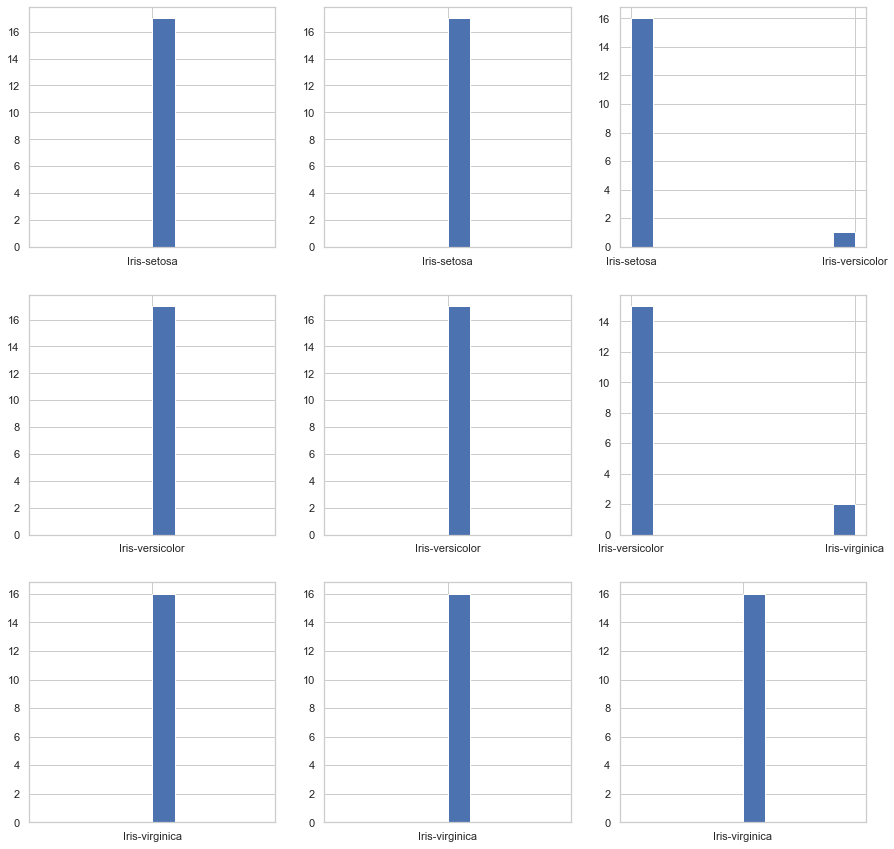

In [16]:
plt.figure(figsize=(15,15))
i = 1

for train, test in cross_validation(data=iris, k_splits=9):
    plt.subplot(3, 3, i)
    test['class'].hist()
    i += 1

plt.show()

#### Randomized

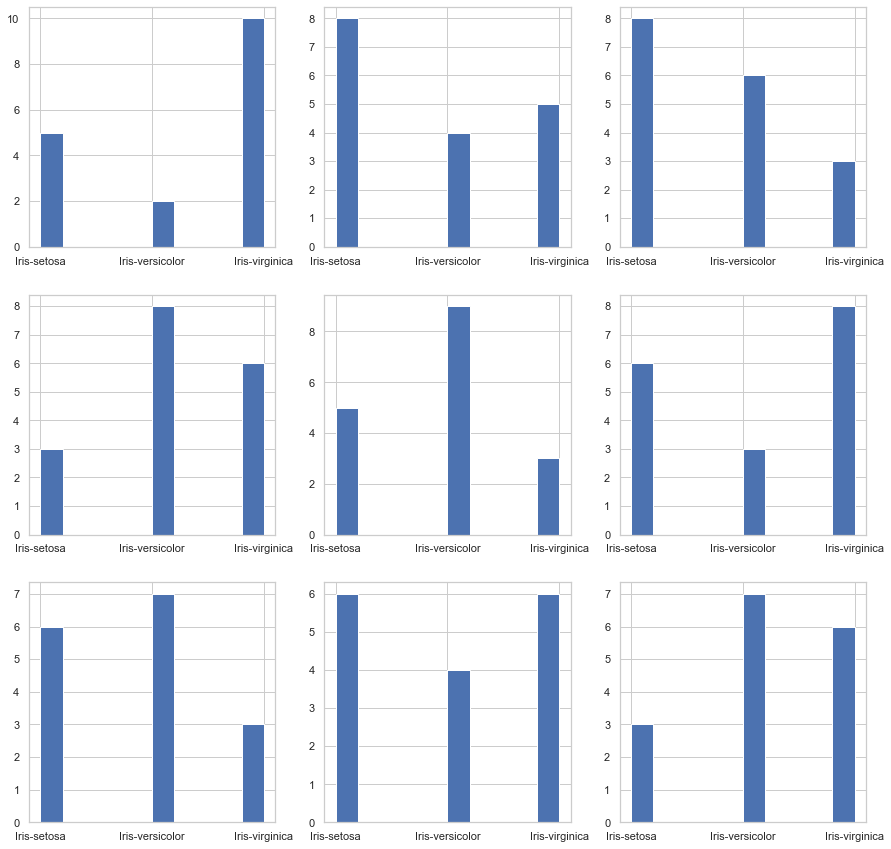

In [17]:
plt.figure(figsize=(15,15))
i = 1

for train, test in cross_validation(data=iris, k_splits=9, shuffle=True):
    plt.subplot(3, 3, i)
    test['class'].hist()
    i += 1

plt.show()

### Leave-One-Out

In [18]:
new, _ = hold_out(data=iris, test_size=0.9, shuffle=True)

new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 6 to 147
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  18 non-null     float64
 1   sepal_width   18 non-null     float64
 2   petal_length  18 non-null     float64
 3   petal_width   18 non-null     float64
 4   class         18 non-null     object 
dtypes: float64(4), object(1)
memory usage: 864.0+ bytes


In [19]:
def leave_one_out(*, data: pd.core.frame.DataFrame, columns: list = []):
    
    for train, test in cross_validation(data=data, k_splits=len(data), shuffle=False, columns=columns):
        yield train, test

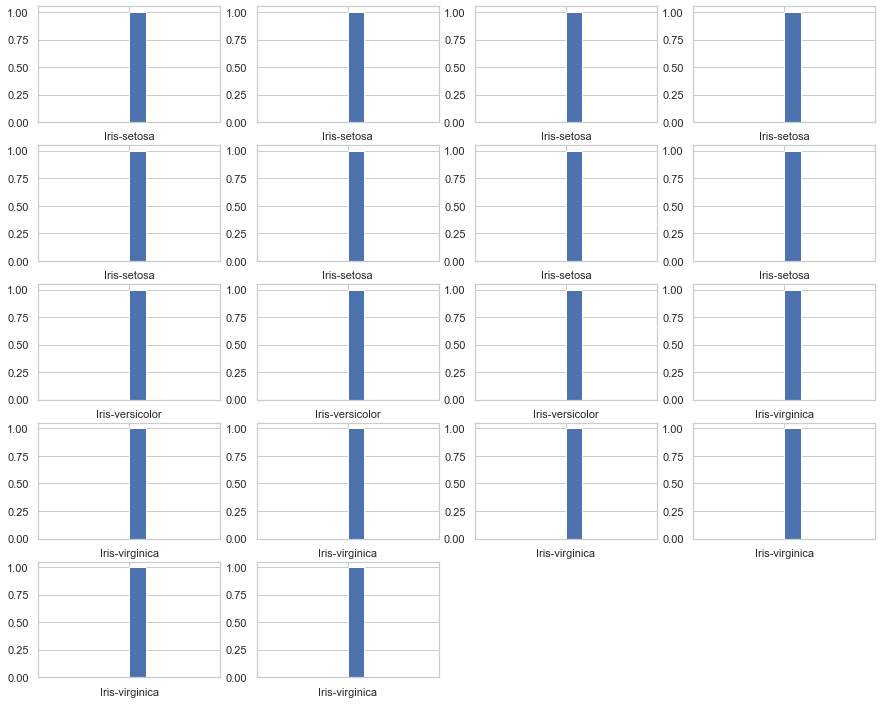

In [20]:
plt.figure(figsize=(15, 20))
i = 1

for train, test in leave_one_out(data=new, columns=['class']):
    plt.subplot(8, 4, i)
    test['class'].hist()
    i += 1

plt.show()

### Binary classification

#### ROC curve and AUC score

In [21]:
labels = [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
scores = [-0.6, 0.9, 1.3, 0.6, 5, -2, 0, 1, 1.5, 3, 0.2, 5]

In [22]:
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

print('AUC: {}'.format(roc_auc))

AUC: 1.0


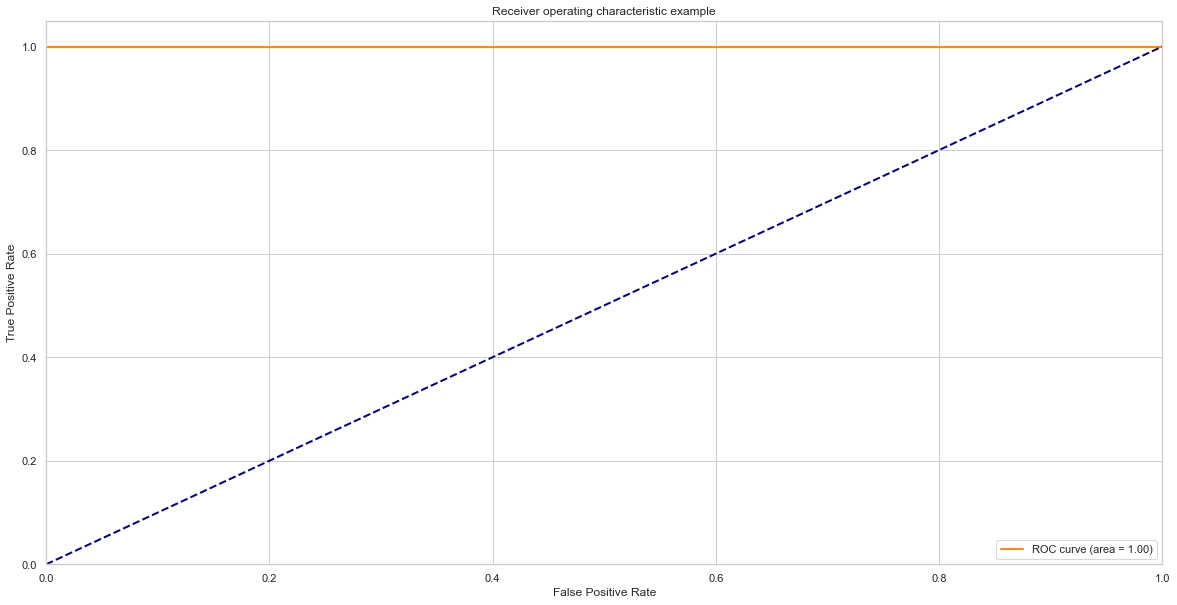

In [23]:
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()